# 📊 CBIS-DDSM 乳房攝影分類專案報告（ResNet）

## 🔖 描述
本專案使用 **CBIS-DDSM** 醫學影像資料集，透過 **ResNet50 預訓練模型**，進行乳房攝影影像的 **良性（Benign）與惡性（Malignant）腫瘤二分類**。

---

## 📌 內容
為了找出最佳的影像輸入策略，實驗比較三種不同的影像來源對分類效能的影響，包括：
- Full Mammogram（完整影像）
- Cropped Mammogram（病灶裁切影像）
- ROI Mask Image（病灶遮罩）

**此資料集為jpeg原始資料集（163GB）的格式。分辨率與原始資料集保持一致。**

* Number of Studies:6775
* Number of Series:6775
* Number of Participants:1,566（註）
* Number of Images:10239
* Modalities:MG
* Image Size (GB):6（.jpg）

**注意：此集合的圖像資料結構如下：每個參與者都有多個患者 ID。例如，pat_id 00038 有 10 個獨立的患者 ID，這些 ID 提供了 ID 內掃描的相關資訊（例如 Calc-Test_P_00038_LEFT_CC、Calc-Test_P_00038_RIGHT_CC_1）。根據 DICOM 元數據，這表示該隊列中有 6,671 名參與者，但實際參與者只有 1,566 名。**

---

## 🎯 專案目標
- 構建二分類模型以判斷腫瘤為良性或惡性  
- 探討三種影像輸入對分類準確率的影響  
- 透過統一架構比較模型表現，找出最佳輸入方式  

---

## 🗂️ 資料來源與處理

- **資料集**：CBIS-DDSM（Curated Breast Imaging Subset of DDSM）  
- **影像來源類型**：
  - `image file path`：完整乳房影像（Full）
  - `cropped image file path`：病灶局部裁切影像（Cropped）
  - `ROI mask file path`：病灶遮罩（ROI）

- **標籤處理**：
  - `BENIGN`, `BENIGN_WITHOUT_CALLBACK` → `0`  
  - `MALIGNANT` → `1`

- **影像前處理**：
  - 尺寸統一為 `224x224`
  - 兩類別皆擴張至`5000`張
  - 使用 ImageNet 標準均值與標準差進行正規化  
  - Cropped 與 ROI 圖像可互換作為輸入來源

---

## 🧠 模型架構與訓練設定

- **模型**：ResNet50（使用 ImageNet 預訓練權重）  
- **輸出層**：將 `fc` 層替換為 2 類輸出 (`nn.Linear(..., 2)`)  
- **損失函數**：CrossEntropyLoss  
- **優化器**：Adam（學習率 1e-4）  
- **訓練設定**：
  - Epochs：20  
  - Batch size：16  
  - 切分比例：70% 訓練 / 20% 驗證 / 10% 測試

---

## 📈 評估指標

- **準確率（Accuracy）**  
- **分類報告**（Precision、Recall、F1-score）  
- **混淆矩陣（Confusion Matrix）**

透過 `sklearn.metrics` 評估模型預測效能，並以混淆矩陣視覺化誤判情況。

---

## ✅ 實驗內容概要

- 使用相同 ResNet50 架構與訓練流程，分別測試以下輸入方式：
  1. Full Mammogram
  2. Cropped Mammogram
  3. ROI Mask Image
- 比較各種輸入對模型在測試集上的分類效果
- 記錄每一種輸入所對應的 Accuracy、F1-score 與錯誤預測樣本
- 分析哪種輸入策略能更有效幫助模型識別惡性腫瘤（提升 Recall）


In [1]:
import numpy as np
import pandas as pd 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


In [2]:
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
print(df_dicom.info())
print("\n" + "-"*50 + "\n")
df_dicom.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0


In [3]:
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path

cropped_images[0]

'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg'

In [4]:
#imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'
imdir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammos = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_imgs = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

cropped_images.iloc[0]

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg'

In [5]:
dic_cropped_images = dict()
dic_full_mammos = dict()
dic_roi_imgs = dict()

for cropped_image in cropped_images:
    key = cropped_image.split("/")[5]
    value = cropped_image
    dic_cropped_images[key] = value
for full_mammo in full_mammos:
    key = full_mammo.split("/")[5]
    value = full_mammo
    dic_full_mammos[key] = value
for roi_img in roi_imgs:
    key = roi_img.split("/")[5]
    value = roi_img
    dic_roi_imgs[key] = value

dic_cropped_images['1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304']

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg'

In [6]:
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

print(mass_train.info())
print("\n" + "-"*50 + "\n")
mass_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...


In [7]:
mass_train['image file path'][0].split("/")

['Mass-Training_P_00001_LEFT_CC',
 '1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994',
 '1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515',
 '000000.dcm']

In [8]:
#dic_full_mammos['1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994']
dic_full_mammos['1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515']

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'

In [9]:
def fix_path(dataset):
    for idx in range(len(dataset)):
        # full mammograms
        old_key = dataset.loc[idx, 'image file path'].split("/")[2]
        dataset.loc[idx, 'image file path'] = dic_full_mammos[old_key]

        # cropped images
        old_key = dataset.loc[idx, 'cropped image file path'].split("/")[2]
        dataset.loc[idx, 'cropped image file path'] = dic_cropped_images[old_key]

        # ROI mask images
        old_key = dataset.loc[idx, 'ROI mask file path'].split("/")[2]
        dataset.loc[idx, 'ROI mask file path'] = dic_roi_imgs[old_key]


In [10]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

fix_path(mass_train)
fix_path(mass_test)

In [11]:
#測試是否改path
assert mass_test['ROI mask file path'][0].split("/")[1]=='kaggle',"Fail_rename_path error"

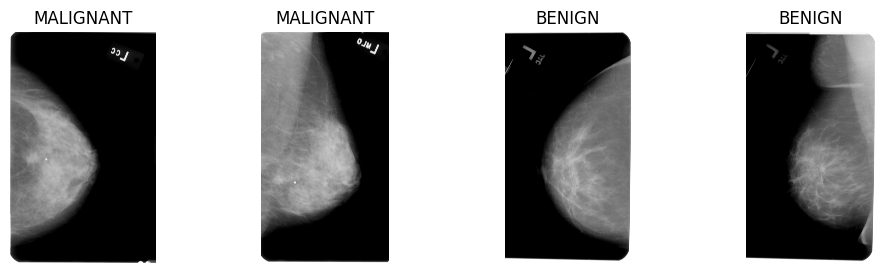

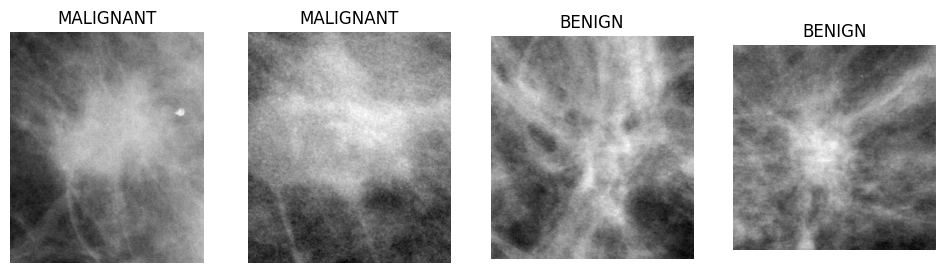

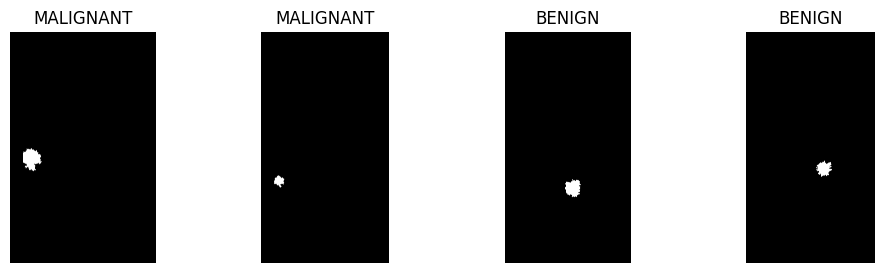

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def show_images(df, path_col, n=5, title_col="pathology"):
    """
    顯示前 n 張影像。

    :param df:        資料表 (pandas.DataFrame)
    :param path_col:  影像檔路徑欄位名稱
    :param n:         要顯示的張數，預設 5
    :param title_col: 子標題欄位名稱，預設 "pathology"
    """
    subset = df.head(n)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))

    for ax, (_, row) in zip(axes, subset.iterrows()):
        ax.imshow(mpimg.imread(row[path_col]), cmap="gray")
        ax.set_title(row[title_col])
        ax.axis("off")

    plt.show()



show_images(mass_train, "image file path", n=4)
show_images(mass_train, "cropped image file path", n=4)
show_images(mass_train, "ROI mask file path", n=4)


# 1. cropped image

## 前處理-資料平衡、資料擴增 -1

In [13]:
import os, uuid, random, gc
from typing import List
from PIL import Image
import torch
import torchvision.transforms as T

def balance_and_augment(images: List[str], labels: List[int], dest: str, target: int = 0):
    """
    對影像資料進行類別平衡與資料增強，並儲存至指定資料夾中。

    :param images: List[str]，原始圖片的路徑清單
    :param labels: List[int]，對應每張圖片的分類標籤（0 或 1）
    :param dest: str，輸出目錄，會在其中建立 '0/' 和 '1/' 子資料夾儲存各類別影像
    :param target: int，最終每一類要達到的圖片數量；若為 0 則僅進行平衡，不擴增到特定張數
    """
    transform = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2)
    ])

    os.makedirs(f'{dest}/0', exist_ok=True)
    os.makedirs(f'{dest}/1', exist_ok=True)
    lists = {0: [], 1: []}

    for path, label in zip(images, labels):
        try:
            with Image.open(path) as img:
                img = img.convert('RGB')
                fn = f"{uuid.uuid4().hex}_{os.path.basename(path)}"
                transform(img).save(os.path.join(dest, str(label), fn), 'JPEG')
                lists[label].append(fn)
        except: continue

    def expand(lst, label, n):
        folder = os.path.join(dest, str(label))
        for i in range(n - len(os.listdir(folder))):
            name = random.choice(lst)
            with Image.open(os.path.join(folder, name)) as img:
                img = img.convert('RGB')
                base = os.path.splitext(name)[0]
                transform(img).save(os.path.join(folder, f"{base}_aug{i}.jpg"), 'JPEG')

    a, b = len(lists[0]), len(lists[1])
    if a < b: expand(lists[0], 0, b)
    elif b < a: expand(lists[1], 1, a)
    if target:
        expand(lists[0], 0, target)
        expand(lists[1], 1, target)
    print(f"After : 0 = {len(os.listdir(dest+'/0'))} | 1 = {len(os.listdir(dest+'/1'))}")


In [14]:
cropped_mass = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)
dummy_map = {"MALIGNANT": 1, "BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 0}
cropped_mass["label"] = cropped_mass["pathology"].replace(dummy_map)

images = list(cropped_mass['cropped image file path'])
labels = list(cropped_mass["label"])
print(f'Before : 0 = {labels.count(0)} | 1 = {labels.count(1)} | '
      f'total = {len(labels)}')

Before : 0 = 912 | 1 = 784 | total = 1696


In [15]:
balance_and_augment(
    images=images,
    labels=labels,
    dest='/kaggle/working/augmented_images',
    target=5000  
)
#import shutil
#shutil.rmtree('/kaggle/working/augmented_images', ignore_errors=True)


After : 0 = 5000 | 1 = 5000


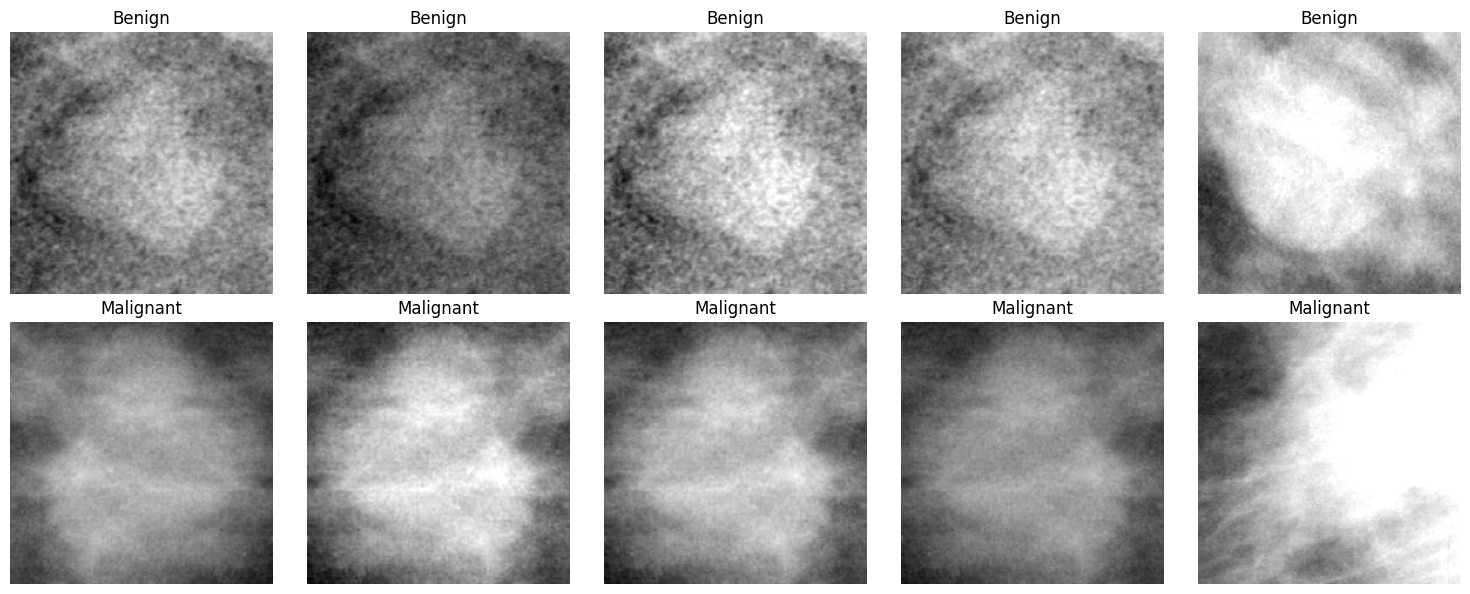

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_augmented_images(folder, n=5):
    """
    顯示 merged/augmented 資料夾中每一類的前 n 張影像。
    
    :param folder: merged 資料夾的路徑（應包含 0/ 和 1/ 子資料夾）
    :param n: 每個類別顯示的圖片數量
    """
    class_names = ['Benign', 'Malignant']
    fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))

    for class_idx in [0, 1]:
        class_dir = os.path.join(folder, str(class_idx))
        images = sorted(os.listdir(class_dir))[:n]

        for i, image_name in enumerate(images):
            img_path = os.path.join(class_dir, image_name)
            img = mpimg.imread(img_path)
            ax = axes[class_idx][i]
            ax.imshow(img)
            ax.set_title(f"{class_names[class_idx]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

show_augmented_images("/kaggle/working/augmented_images", n=5)


## Model training -1

In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [18]:
full_dataset = datasets.ImageFolder('/kaggle/working/augmented_images', transform=data_transform)

lengths = [int(len(full_dataset) * 0.7), int(len(full_dataset) * 0.2)]
lengths.append(len(full_dataset) - sum(lengths))
train_ds, val_ds, test_ds = random_split(full_dataset, lengths, generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [19]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # for binary classification

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [21]:
best_acc = 0
for epoch in range(5):
    model.train()
    running_loss = 0
    total_batches = 0
    train_correct, train_total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_batches += 1

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_loss = running_loss / total_batches
    train_acc = train_correct / train_total

    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f'Epoch {epoch+1} | Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f} | Train Loss: {avg_loss:.4f} | '
          f'Val Loss: {val_loss:.4f}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "cropped_best_model.pth")

Epoch 1 | Train Acc: 0.7861 | Val Acc: 0.8870 | Train Loss: 0.4492 | Val Loss: 0.2605
Epoch 2 | Train Acc: 0.9281 | Val Acc: 0.9065 | Train Loss: 0.1849 | Val Loss: 0.2524
Epoch 3 | Train Acc: 0.9676 | Val Acc: 0.9285 | Train Loss: 0.0825 | Val Loss: 0.2173
Epoch 4 | Train Acc: 0.9751 | Val Acc: 0.9590 | Train Loss: 0.0715 | Val Loss: 0.1372
Epoch 5 | Train Acc: 0.9859 | Val Acc: 0.9560 | Train Loss: 0.0385 | Val Loss: 0.1603


## Confusion Matrix -1

Test Accuracy: 0.9480


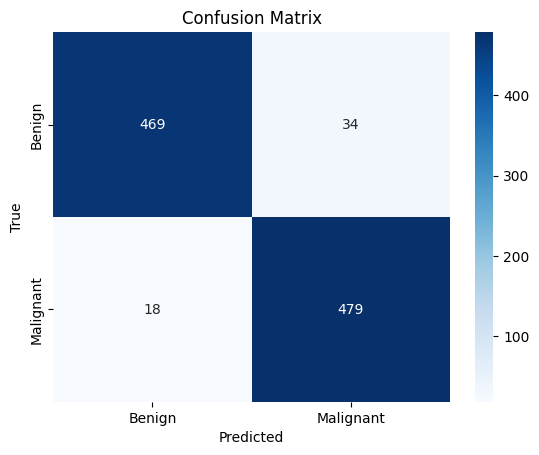

In [22]:
model.load_state_dict(torch.load("cropped_best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.9337
Recall:    0.9638
F1-score:  0.9485


# 2. ROI image

## 前處理-資料平衡、資料擴增 -2

In [24]:
roi_mass = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)
dummy_map = {"MALIGNANT": 1, "BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 0}
roi_mass["label"] = roi_mass["pathology"].replace(dummy_map)

images = list(roi_mass['ROI mask file path'])
labels = list(roi_mass["label"])
print(f'Before : 0 = {labels.count(0)} | 1 = {labels.count(1)} | '
      f'total = {len(labels)}')

Before : 0 = 912 | 1 = 784 | total = 1696


In [25]:
balance_and_augment(
    images=images,
    labels=labels,
    dest='/kaggle/working/augmented_roi_images',
    target=5000  
)
#import shutil
#shutil.rmtree('/kaggle/working/augmented_images', ignore_errors=True)


After : 0 = 5000 | 1 = 5000


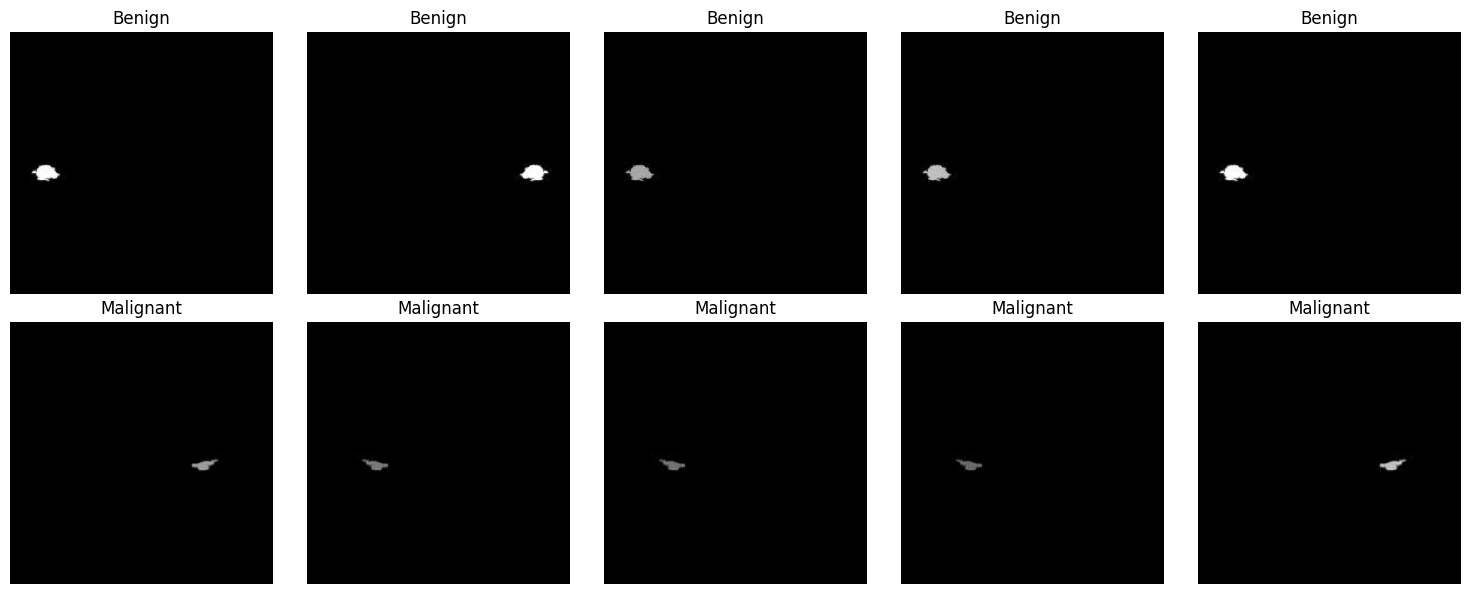

In [26]:
show_augmented_images("/kaggle/working/augmented_roi_images", n=5)

In [27]:
full_dataset = datasets.ImageFolder('/kaggle/working/augmented_roi_images', transform=data_transform)

lengths = [int(len(full_dataset) * 0.7), int(len(full_dataset) * 0.2)]
lengths.append(len(full_dataset) - sum(lengths))
train_ds, val_ds, test_ds = random_split(full_dataset, lengths, generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [28]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # for binary classification
# Step 6: Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model training -2

In [29]:
best_acc = 0
for epoch in range(5):
    model.train()
    running_loss = 0
    total_batches = 0
    train_correct, train_total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_batches += 1

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_loss = running_loss / total_batches
    train_acc = train_correct / train_total

    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f'Epoch {epoch+1} | Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f} | Train Loss: {avg_loss:.4f} | '
          f'Val Loss: {val_loss:.4f}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "roi_best_model.pth")

Epoch 1 | Train Acc: 0.6130 | Val Acc: 0.6820 | Train Loss: 0.6581 | Val Loss: 0.5919
Epoch 2 | Train Acc: 0.7287 | Val Acc: 0.7815 | Train Loss: 0.5359 | Val Loss: 0.4674
Epoch 3 | Train Acc: 0.8447 | Val Acc: 0.8330 | Train Loss: 0.3577 | Val Loss: 0.3897
Epoch 4 | Train Acc: 0.9136 | Val Acc: 0.8760 | Train Loss: 0.2181 | Val Loss: 0.3128
Epoch 5 | Train Acc: 0.9470 | Val Acc: 0.9160 | Train Loss: 0.1414 | Val Loss: 0.2409


## Confusion Matrix -2

Test Accuracy: 0.9160


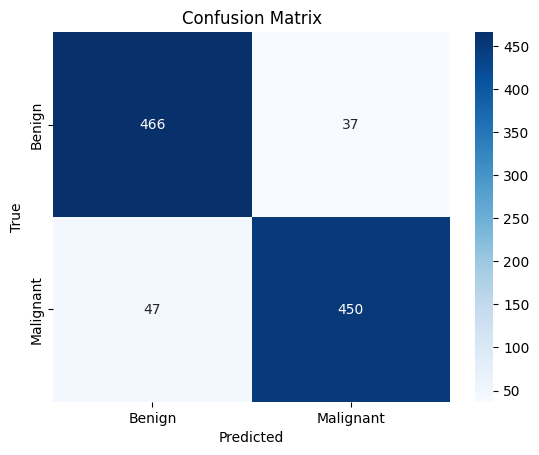

In [30]:
model.load_state_dict(torch.load("roi_best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [31]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.9240
Recall:    0.9054
F1-score:  0.9146


# 3.full mammogram images

## 前處理-資料平衡、資料擴增 -3

In [32]:
full_mass = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)
dummy_map = {"MALIGNANT": 1, "BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 0}
full_mass["label"] = full_mass["pathology"].replace(dummy_map)

images = list(full_mass['image file path'])
labels = list(full_mass["label"])
print(f'Before : 0 = {labels.count(0)} | 1 = {labels.count(1)} | '
      f'total = {len(labels)}')

Before : 0 = 912 | 1 = 784 | total = 1696


In [33]:
balance_and_augment(
    images=images,
    labels=labels,
    dest='/kaggle/working/augmented_full_images',
    target=5000  
)
#import shutil
#shutil.rmtree('/kaggle/working/augmented_full_images', ignore_errors=True)


After : 0 = 5000 | 1 = 5000


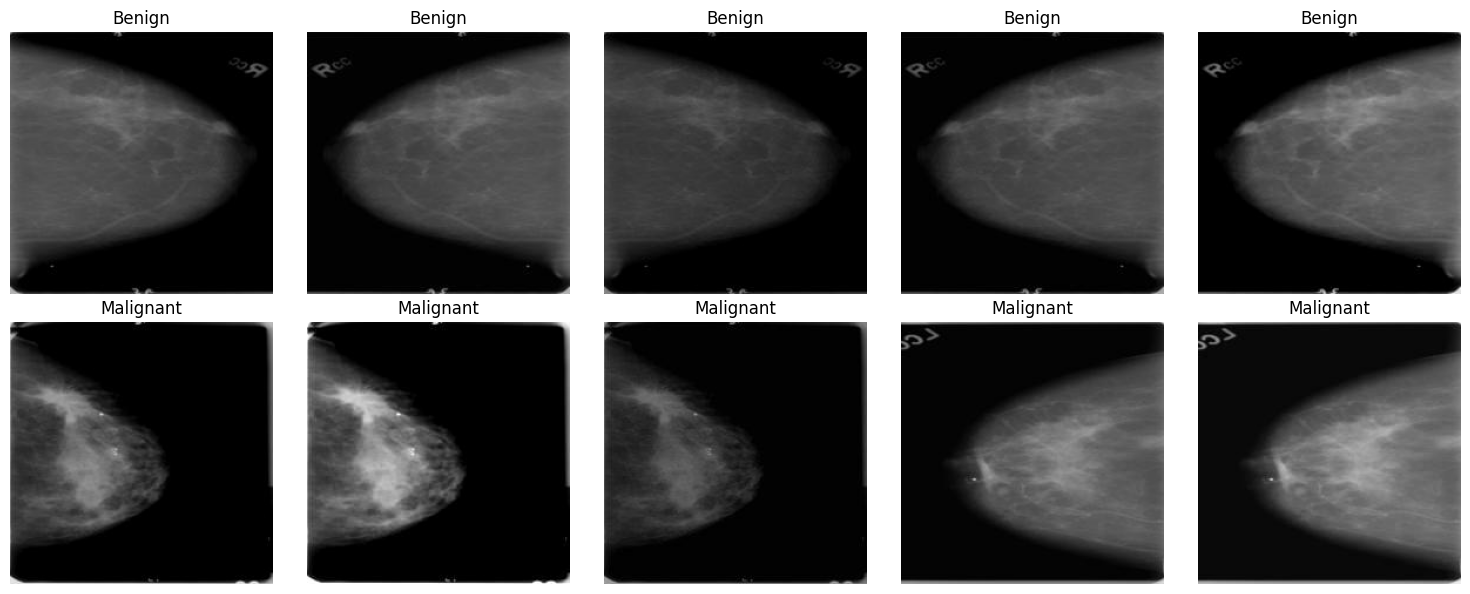

In [34]:
show_augmented_images("/kaggle/working/augmented_full_images", n=5)

## Model training -3

In [35]:
best_acc = 0
for epoch in range(5):
    model.train()
    running_loss = 0
    total_batches = 0
    train_correct, train_total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_batches += 1

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_loss = running_loss / total_batches
    train_acc = train_correct / train_total

    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f'Epoch {epoch+1} | Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f} | Train Loss: {avg_loss:.4f} | '
          f'Val Loss: {val_loss:.4f}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "full_best_model.pth")

Epoch 1 | Train Acc: 0.9707 | Val Acc: 0.9145 | Train Loss: 0.0854 | Val Loss: 0.3221
Epoch 2 | Train Acc: 0.9709 | Val Acc: 0.9150 | Train Loss: 0.0793 | Val Loss: 0.3021
Epoch 3 | Train Acc: 0.9784 | Val Acc: 0.9260 | Train Loss: 0.0651 | Val Loss: 0.2593
Epoch 4 | Train Acc: 0.9819 | Val Acc: 0.9180 | Train Loss: 0.0520 | Val Loss: 0.3169
Epoch 5 | Train Acc: 0.9826 | Val Acc: 0.9220 | Train Loss: 0.0468 | Val Loss: 0.2999


## Confusion Matrix -3

Test Accuracy: 0.9410


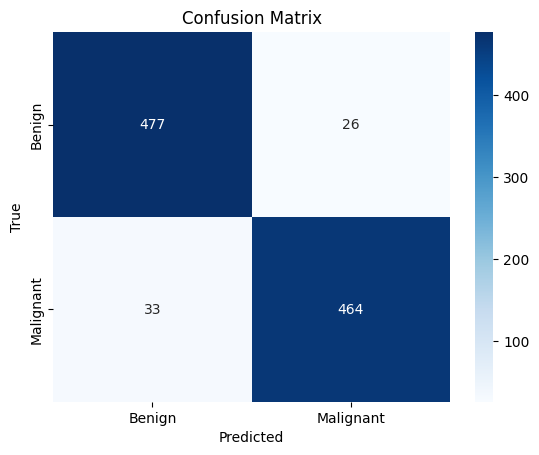

In [36]:
model.load_state_dict(torch.load("full_best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [37]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.9469
Recall:    0.9336
F1-score:  0.9402


# 📘 結論報告（Summary）

- **Cropped Image**：病灶區域裁切圖
- **ROI Image**：病灶遮罩區域圖（Region of Interest）
- **Full Mammogram Image**：原始完整乳房X光圖

模型皆使用預訓練 ResNet50 架構，並針對二分類任務調整輸出層。

---
## 📊 分組訓練與測試成效

### 🟦 第一組：**Cropped Image**（病灶區域裁切圖）

| Epoch | Train Acc | Val Acc | Train Loss | Val Loss |
|-------|-----------|---------|------------|----------|
| 1     | 0.7861    | 0.8870  | 0.4492     | 0.2605   |
| 2     | 0.9281    | 0.9065  | 0.1849     | 0.2524   |
| 3     | 0.9676    | 0.9285  | 0.0825     | 0.2173   |
| 4     | 0.9751    | 0.9590  | 0.0715     | 0.1372   |
| 5     | 0.9859    | 0.9560  | 0.0385     | 0.1603   |

📌 評估指標：

- **Accuracy** : 0.9480
- **Precision**：0.9337
- **Recall**：0.9638
- **F1-score**：0.9485

✅ **整體表現最佳，病灶特徵明確幫助分類**

---

### 🟨 第二組：**ROI Image**（病灶遮罩區域）

| Epoch | Train Acc | Val Acc | Train Loss | Val Loss |
|-------|-----------|---------|------------|----------|
| 1     | 0.6130    | 0.6820  | 0.6581     | 0.5919   |
| 2     | 0.7287    | 0.7815  | 0.5359     | 0.4674   |
| 3     | 0.8447    | 0.8330  | 0.3577     | 0.3897   |
| 4     | 0.9136    | 0.8760  | 0.2181     | 0.3128   |
| 5     | 0.9470    | 0.9160  | 0.1414     | 0.2409   |

📌 評估指標：

- **Accuracy** : 0.9160
- **Precision**：0.9240
- **Recall**：0.9054
- **F1-score**：0.9146

🔍 **收斂穩定，仍需更進階特徵提取以提升泛化力**

---

### 🟩 第三組：**Full Mammogram Image**（完整乳房影像）

| Epoch | Train Acc | Val Acc | Train Loss | Val Loss |
|-------|-----------|---------|------------|----------|
| 1     | 0.9707    | 0.9145  | 0.0854     | 0.3221   |
| 2     | 0.9709    | 0.9150  | 0.0793     | 0.3021   |
| 3     | 0.9784    | 0.9260  | 0.0651     | 0.2593   |
| 4     | 0.9819    | 0.9180  | 0.0520     | 0.3169   |
| 5     | 0.9826    | 0.9220  | 0.0468     | 0.2999   |

📌 評估指標：

- **Accuracy** : 0.9410
- **Precision**：0.9469
- **Recall**：0.9336
- **F1-score**：0.9402

---

## ✅ 分析

- **訓練與驗證表現穩定，驗證準確率維持 91~92%。**
- 高 Precision 表示模型對陽性判斷準確
- 高 Recall 表示能找出大部分陽性樣本
- 整體 F1-score 達 94%，顯示泛化能力良好

---

## 🔍 待加入

- 模組化模型架構 : training loop變成函式。
- 加入更多`assert`、 註解 。
- 加入 Early Stopping 控制 overfitting。

---

## Link@
### Contact Me : 
- [github@yehdanny](https://github.com/yehdanny)
- [Website@yehdanny](https://yehdanny.github.io/mypage/html/index.html)
- [Instagram@yeh_const](https://www.instagram.com/yeh_const?igsh=MTVlNTl2eGVkeWI2MA%3D%3D&utm_source=qr)
### Learn More About Markdown :
- [This Markdown Guide](https://www.markdownguide.org/)
